## Import Libraries and Instiate Deconv Module

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fft2, ifft2
import torchvision
import torchvision.transforms as T
from torchvision import io
from torch.utils.data import Dataset, DataLoader

import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class Deconv2D(nn.Module):
    def __init__(self, shape=(2, 4)):
        super(Deconv2D, self).__init__()
        self.w_flat = nn.Parameter(data=torch.zeros(shape[0]*shape[1]-1),
                                   requires_grad=True)
        self.h_shape = shape

    def forward(self, x):
        w = nn.functional.pad(self.w_flat, (1, 0), value=1)

        w = torch.reshape(w, self.h_shape)
        hm1 = nn.functional.pad(w, (0, x.size(-1)-w.size(-1), 0, x.size(-2)-w.size(-2)))

        gm1f = 1/fft2(hm1)

        gm2f = torch.flip(gm1f, (0,))
        gm2f = torch.roll(gm1f, shifts=1, dims=0)

        gm3f = torch.flip(gm1f, (1,))
        gm3f = torch.roll(gm1f, shifts=1, dims=1)

        gm4f = torch.flip(gm1f, (0, 1))
        gm4f = torch.roll(gm1f, shifts=(1, 1), dims=(0,1))

        gmf = gm1f*gm2f*gm3f*gm4f

        ymf = gmf*fft2(x)

        y = ifft2(ymf).real

        return y

## Load CIFAR Dataset

In [4]:
from torchvision import datasets

transform = T.Compose([T.ToTensor(),
                       T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_data = datasets.CIFAR100("/content/", download=True, transform=transform)
data_len = len(cifar_data)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /content/cifar-100-python.tar.gz to /content/


In [5]:
dataloader = DataLoader(cifar_data, batch_size=32, shuffle=True)

## Create training function

In [6]:
def train_model(model, criterion, optimizer, dataloader, data_len, num_epochs=3):
    history = {'loss':[], 'accuracy':[]}
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1:2d}/{num_epochs}')

        model.train()
        running_loss = 0.0
        running_correct = 0

        for X, labels in tqdm(dataloader):

            X = X.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(True):
                outputs = model(X)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss
            running_correct += torch.sum(preds==labels.data)
        
        epoch_loss = running_loss
        epoch_acc = running_correct/data_len

        history['loss'].append(epoch_loss.item())
        history['accuracy'].append(epoch_acc.item())

        print('Loss: {:.4f}, Acc: {:.3f}'.format(epoch_loss, epoch_acc))
    return history

In [8]:
class ConvNetTiny(nn.Module):
    def __init__(self, deconv=None, classes=10):
        super(ConvNetTiny, self).__init__()

        n_ftrs = 3
        if deconv is None:
            self.deconv = nn.Identity()
            self.conv1 = nn.Conv2d(3, 3, 3, padding='same')
        elif deconv == 'replace':
            self.deconv = Deconv2D((3, 3))
            self.conv1 = nn.Identity()
            n_ftrs = 3
        elif deconv == 'both':
            self.deconv = Deconv2D((3, 3))
            self.conv1 = nn.Conv2d(3, 3, 3, padding='same')
        
        self.bn1 = nn.BatchNorm2d(n_ftrs)

        self.conv2 = nn.Conv2d(n_ftrs, 64, 3, padding='same')
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding='same')
        self.bn3 = nn.BatchNorm2d(128)

        self.maxpool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(8192, 64)
        self.fc2 = nn.Linear(64, 100)

    
    def forward(self, x):
        x = self.deconv(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x


## Train model with no deconv layer

In [9]:
model = ConvNetTiny()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

history = train_model(model, criterion, optimizer, dataloader, data_len, num_epochs=5)

Epoch  1/5


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 5766.1553, Acc: 0.155
Epoch  2/5


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 4711.6450, Acc: 0.274
Epoch  3/5


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 4183.4492, Acc: 0.340
Epoch  4/5


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 3789.7620, Acc: 0.393
Epoch  5/5


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 3480.9431, Acc: 0.439


## Train model with deconv layer

In [ ]:
model = ConvNetTiny("replace")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

history_replace = train_model(model, criterion, optimizer, dataloader, data_len, num_epochs=5)
print(model.deconv.w_flat)

Epoch  1/5


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 2297.5071, Acc: 0.479
Epoch  2/5


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 1810.8589, Acc: 0.593
Epoch  3/5


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 1611.6143, Acc: 0.642
Epoch  4/5


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 1474.0505, Acc: 0.671
Epoch  5/5


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 1349.4166, Acc: 0.701
Parameter containing:
tensor([-0.0083,  0.0446,  0.0126,  0.0051,  0.0379,  0.0388,  0.0345,  0.0483],
       requires_grad=True)


## Train model with Deconv and Conv layer

In [ ]:
model = ConvNetTiny("both")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

history_both = train_model(model, criterion, optimizer, dataloader, data_len, num_epochs=5)
print(model.deconv.w_flat)

Epoch  1/5


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 2185.8965, Acc: 0.503
Epoch  2/5


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 1689.5563, Acc: 0.621
Epoch  3/5


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 1479.6014, Acc: 0.670
Epoch  4/5


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 1334.2891, Acc: 0.706
Epoch  5/5


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 1219.6980, Acc: 0.728
Parameter containing:
tensor([-0.0278,  0.0292, -0.0048, -0.0133,  0.0339,  0.0265,  0.0062,  0.0205],
       requires_grad=True)


Text(0.5, 1.0, 'Accuracy')

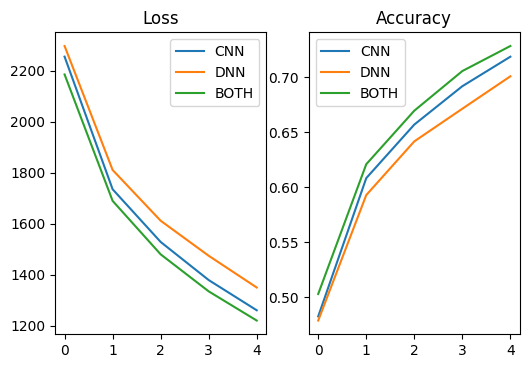

In [ ]:
plt.rcParams['figure.dpi'] = 100
plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.plot(history['loss'])
plt.plot(history_replace['loss'])
plt.plot(history_both['loss'])
plt.legend(['CNN', 'DNN', 'BOTH'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'])
plt.plot(history_replace['accuracy'])
plt.plot(history_both['accuracy'])
plt.legend(['CNN', 'DNN', 'BOTH'])
plt.title('Accuracy')